#Casting the Net:  Machine Learning for Phishing Website Detection

Phishing is a common source of fraud on the internet that can have
devastating effects on the lives of its victims. The goal of this project is to
produce a model that can quickly identify whether or not a URL presented to a
user is malicious as well as provide an intuitive understanding as to why the
URL in question is malicious (or not) by extracting insights from the model
itself using established techniques such as feature importance and partial
dependence plotting. The dataset used is composed of **88,647**
training examples with **111 features** in total (the features are categorised into
implicit groups that correspond to specific parts of a URLs anatomy such as
the domain or protocol). Binary Cross-Entropy loss, accuracy, precision,
recall, and confusion matrices will be used to evaluate the performance of the
model. The main challenges will likely revolve around extracting meaningful
insights from the trained model using the previously mentioned techniques;
their respective implementations are likely to give way to unforeseen
challenges that will need to be dealt with.

##the problem
Users online are often not capable of distinguishing malicious URLs from
legitimate ones. While anti-phishing tools like spam filters and browser plugins
are often successful in preventing exposure to malicious websites, they fail to
educate the user as to why the URL in question was malicious to begin with.
This leaves the user vulnerable to phishing attacks when such tools
malfunction, or simply not at their disposal, hence the reason why it is
important that users are able to leverage learned intuitions to avoid phishing
attacks unassisted.

##the solution
The solution consists of two parts: 

The classification of an URL as legitimate
or malicious using **Decision Trees** and **Random Forests**

Model behaviour is examined by extracting feature importances and SHAP values. The goal of this is to pinpoint patterns and elements that they
are likely to identify in other malicious URLs they may come across.

In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sklearn.ensemble
import sklearn.inspection
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
!pip install shap
import shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 10.1 MB/s eta 0:00:00


##**Data Processing**

https://data.mendeley.com/datasets/72ptz43s9v/1

Total number of instances: 88,647 \\
Number of legitimate website instances (labeled as 0): 58,000 \\
Number of phishing website instances (labeled as 1): 30,647 \\
Total number of features: 111 \\

train size = 62052 samples (70% of dataset) \\
test size = 26595 samples (30% of the dataset)

**why use a imbalanced dataset?**

Due to the fact that most websites are legitimate rather than fraudulent, the imbalance reflects the reality of the problem space. While the code below can be configured to use a balanced or imbalanced dataset, the model performs better when the imbalanced dataset is used. 

In [3]:
# dataset = pd.read_csv('dataset_full.csv')

# feature_names = list(dataset.columns.values)[:111]
# num_features = len(feature_names)

# useBalanced = False

# dataset_phishing = dataset[dataset["phishing"] == 1]
# dataset_safe = dataset[dataset["phishing"] == 0]

# if useBalanced == True:
#   dataset = pd.concat([dataset_phishing, dataset_safe[:len(dataset_phishing)]], axis=0).sample(frac=1)
# else: 
#   dataset = pd.concat([dataset_phishing, dataset_safe], axis=0).sample(frac=1)

# train, test = train_test_split(dataset, test_size=0.3)

# X_train = train.iloc[:, 0:111]
# y_train = train['phishing']

# X_test = test.iloc[:, 0:111]
# y_test = test['phishing']
 
# X_train_torch = torch.Tensor(X_train.values)
# y_train_torch = torch.Tensor(y_train.values)

# X_test_torch = torch.Tensor(X_test.values)
# y_test_torch = torch.Tensor(y_test.values)

In [8]:
dataset = pd.read_csv('dataset_full.csv')

feature_names = list(dataset.columns.values)[:111]
num_features = len(feature_names)

useBalanced = False

# dataset_phishing = dataset[dataset["phishing"] == 1]
# dataset_safe = dataset[dataset["phishing"] == 0]

X, y = dataset.iloc[:,0:111], dataset['phishing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.2)


# if useBalanced == True:
#   dataset = pd.concat([dataset_phishing, dataset_safe[:len(dataset_phishing)]], axis=0).sample(frac=1)
# else: 
#   dataset = pd.concat([dataset_phishing, dataset_safe], axis=0).sample(frac=1)

# train, test = train_test_split(dataset, test_size=0.3)

# X_train = train.iloc[:, 0:111]
# y_train = train['phishing']

# X_test = test.iloc[:, 0:111]
# y_test = test['phishing']
 
X_train_torch = torch.Tensor(X_train.values)
y_train_torch = torch.Tensor(y_train.values).long()

X_test_torch = torch.Tensor(X_test.values)
y_test_torch = torch.Tensor(y_test.values).long()

#**Decision Tree Implementation**

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train);

y_pred = tree.predict(X_train)

training_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

y_pred = tree.predict(X_test)

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('{:.2%} training accuracy'.format(training_accuracy))
print('{:.2%} training error'.format(1-training_accuracy))
print('{:.2%} test accuracy'.format(test_accuracy))
print('{:.2%} test error'.format(1-test_accuracy))

100.00% training accuracy
0.00% training error
95.08% test accuracy
4.92% test error


##Feature Importances

###Mean Decrease In Impurity (MDI)

In [ ]:
importances = tree.feature_importances_
std = np.std([tree.feature_importances_], axis=0)
tree_importances = pd.Series(importances, index=feature_names)

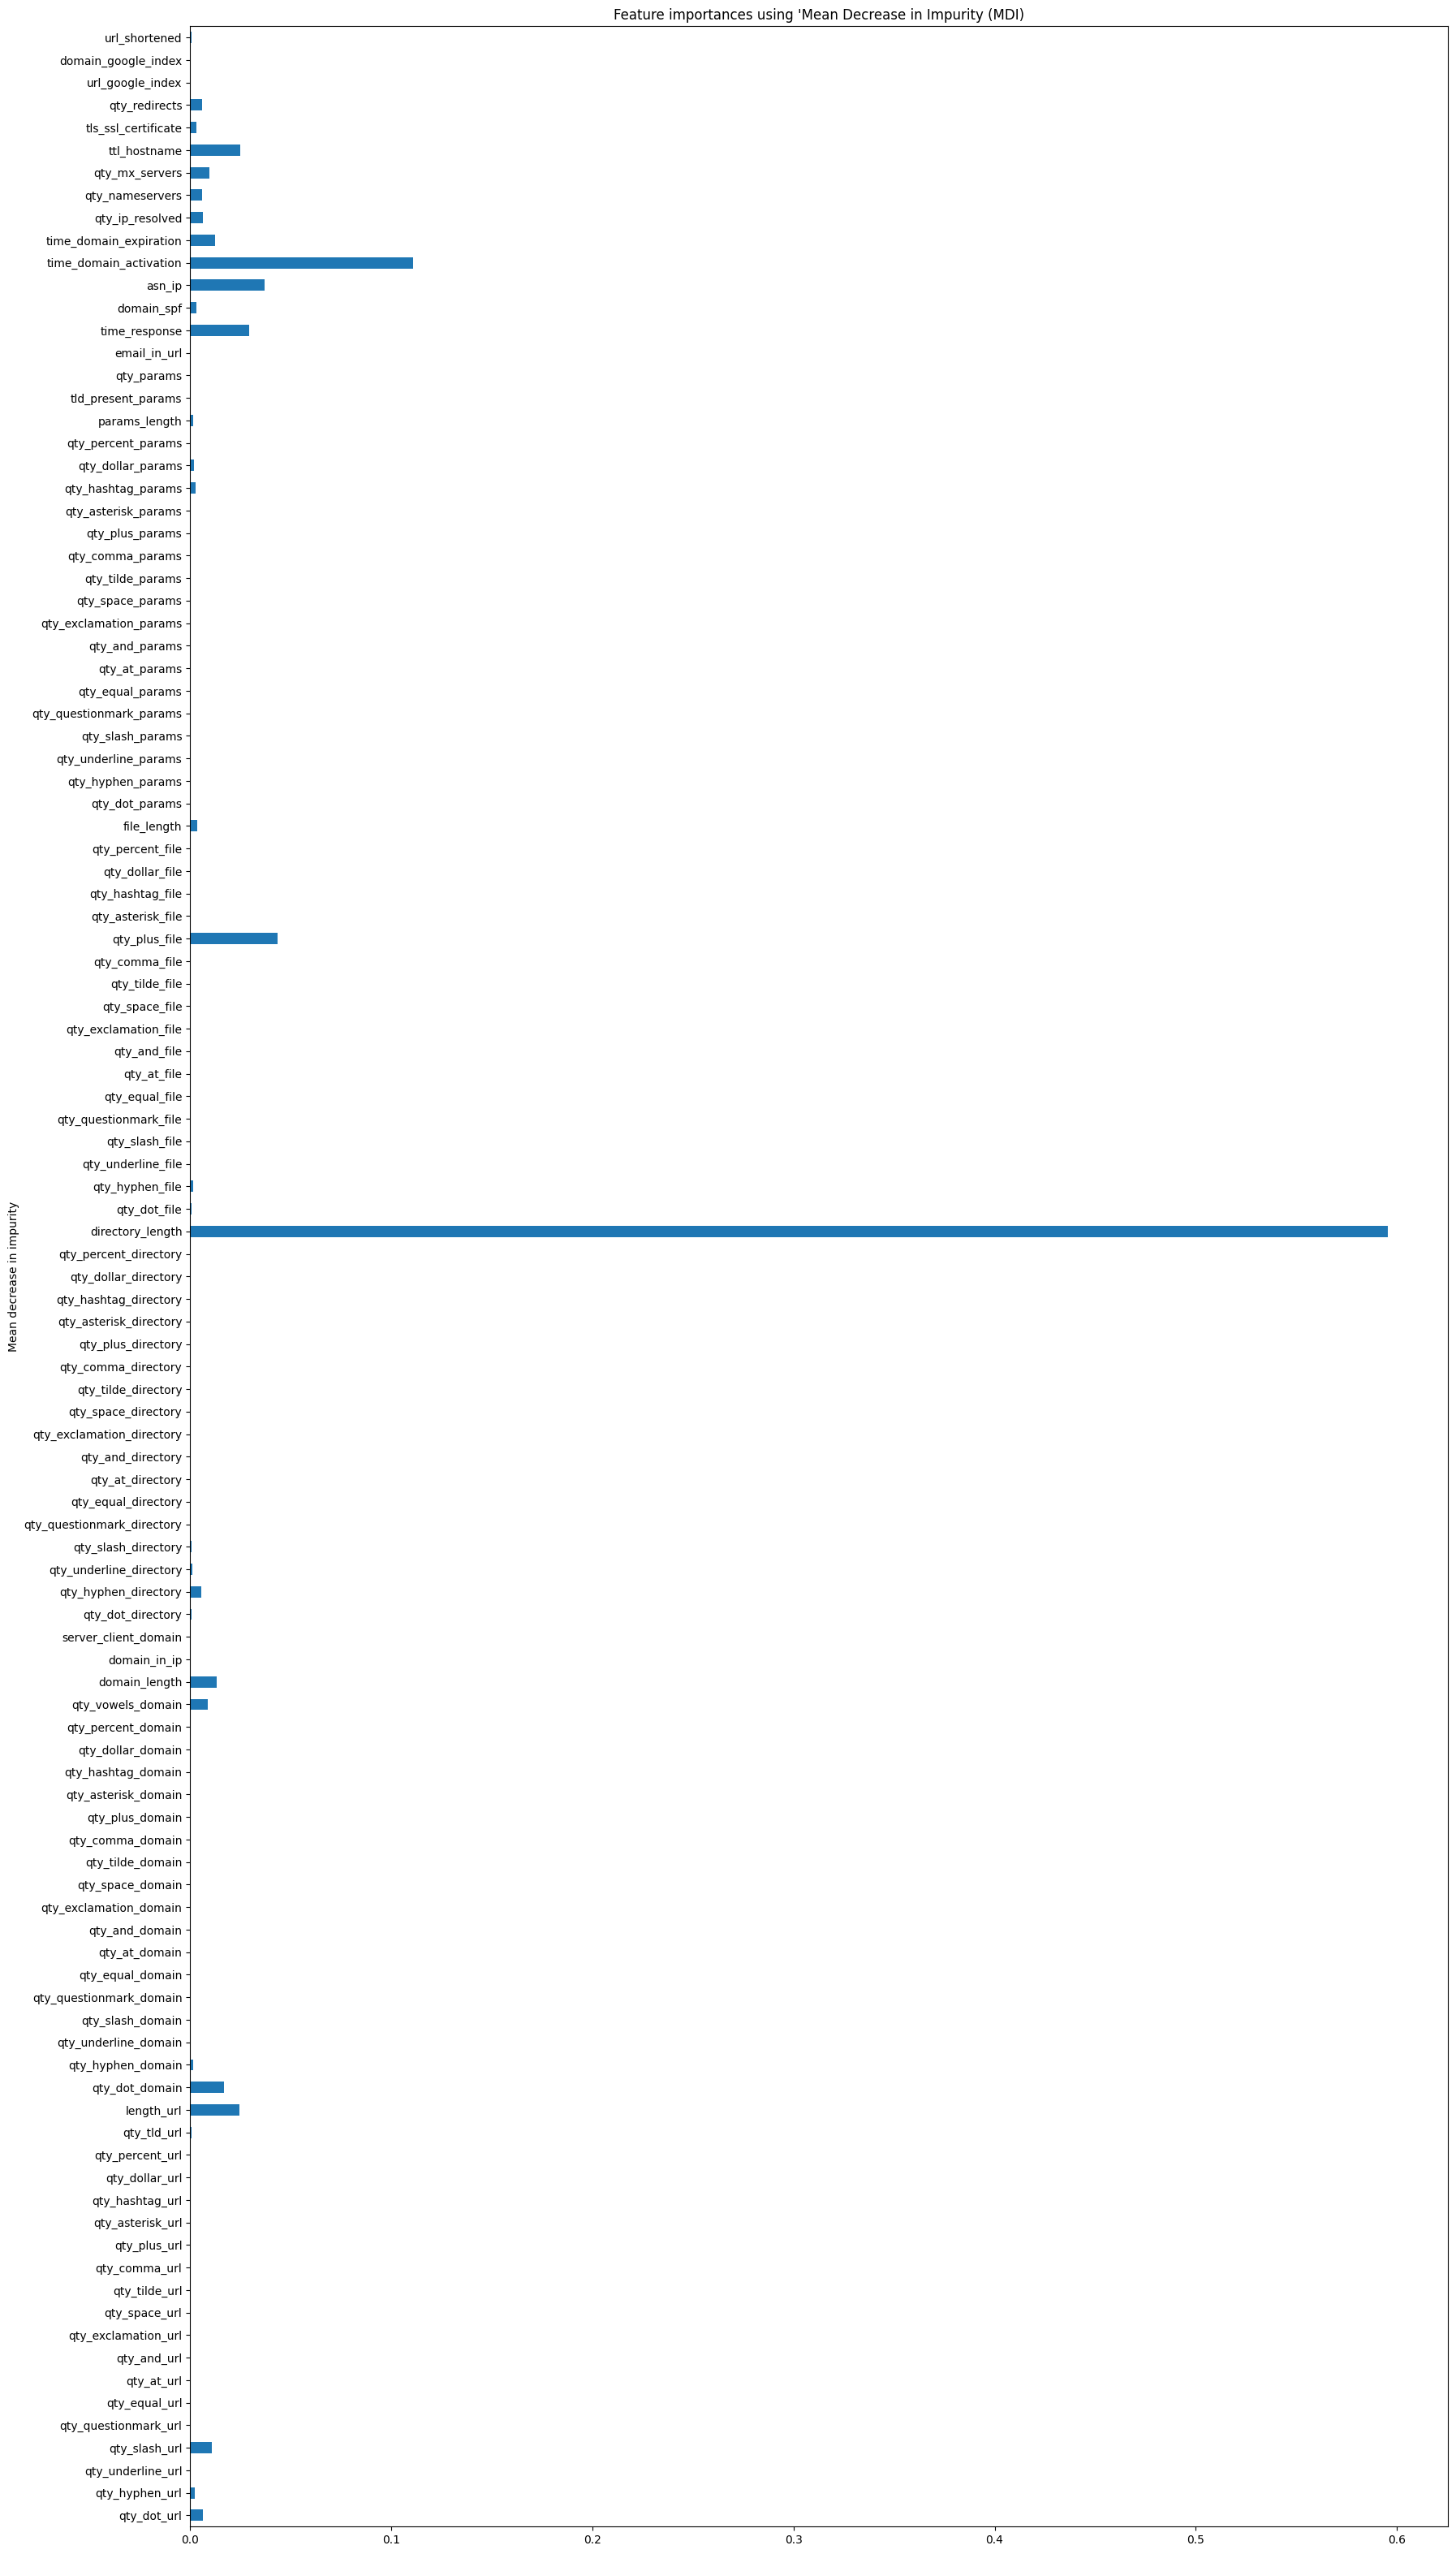

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20,40)
tree_importances.plot.barh(yerr=std, ax=ax, align='center')
plt.title("Feature importances using 'Mean Decrease in Impurity (MDI)")
plt.ylabel("Mean decrease in impurity");

###Feature Permutation



In [ ]:
result = permutation_importance(tree, X_vali, y_vali, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean

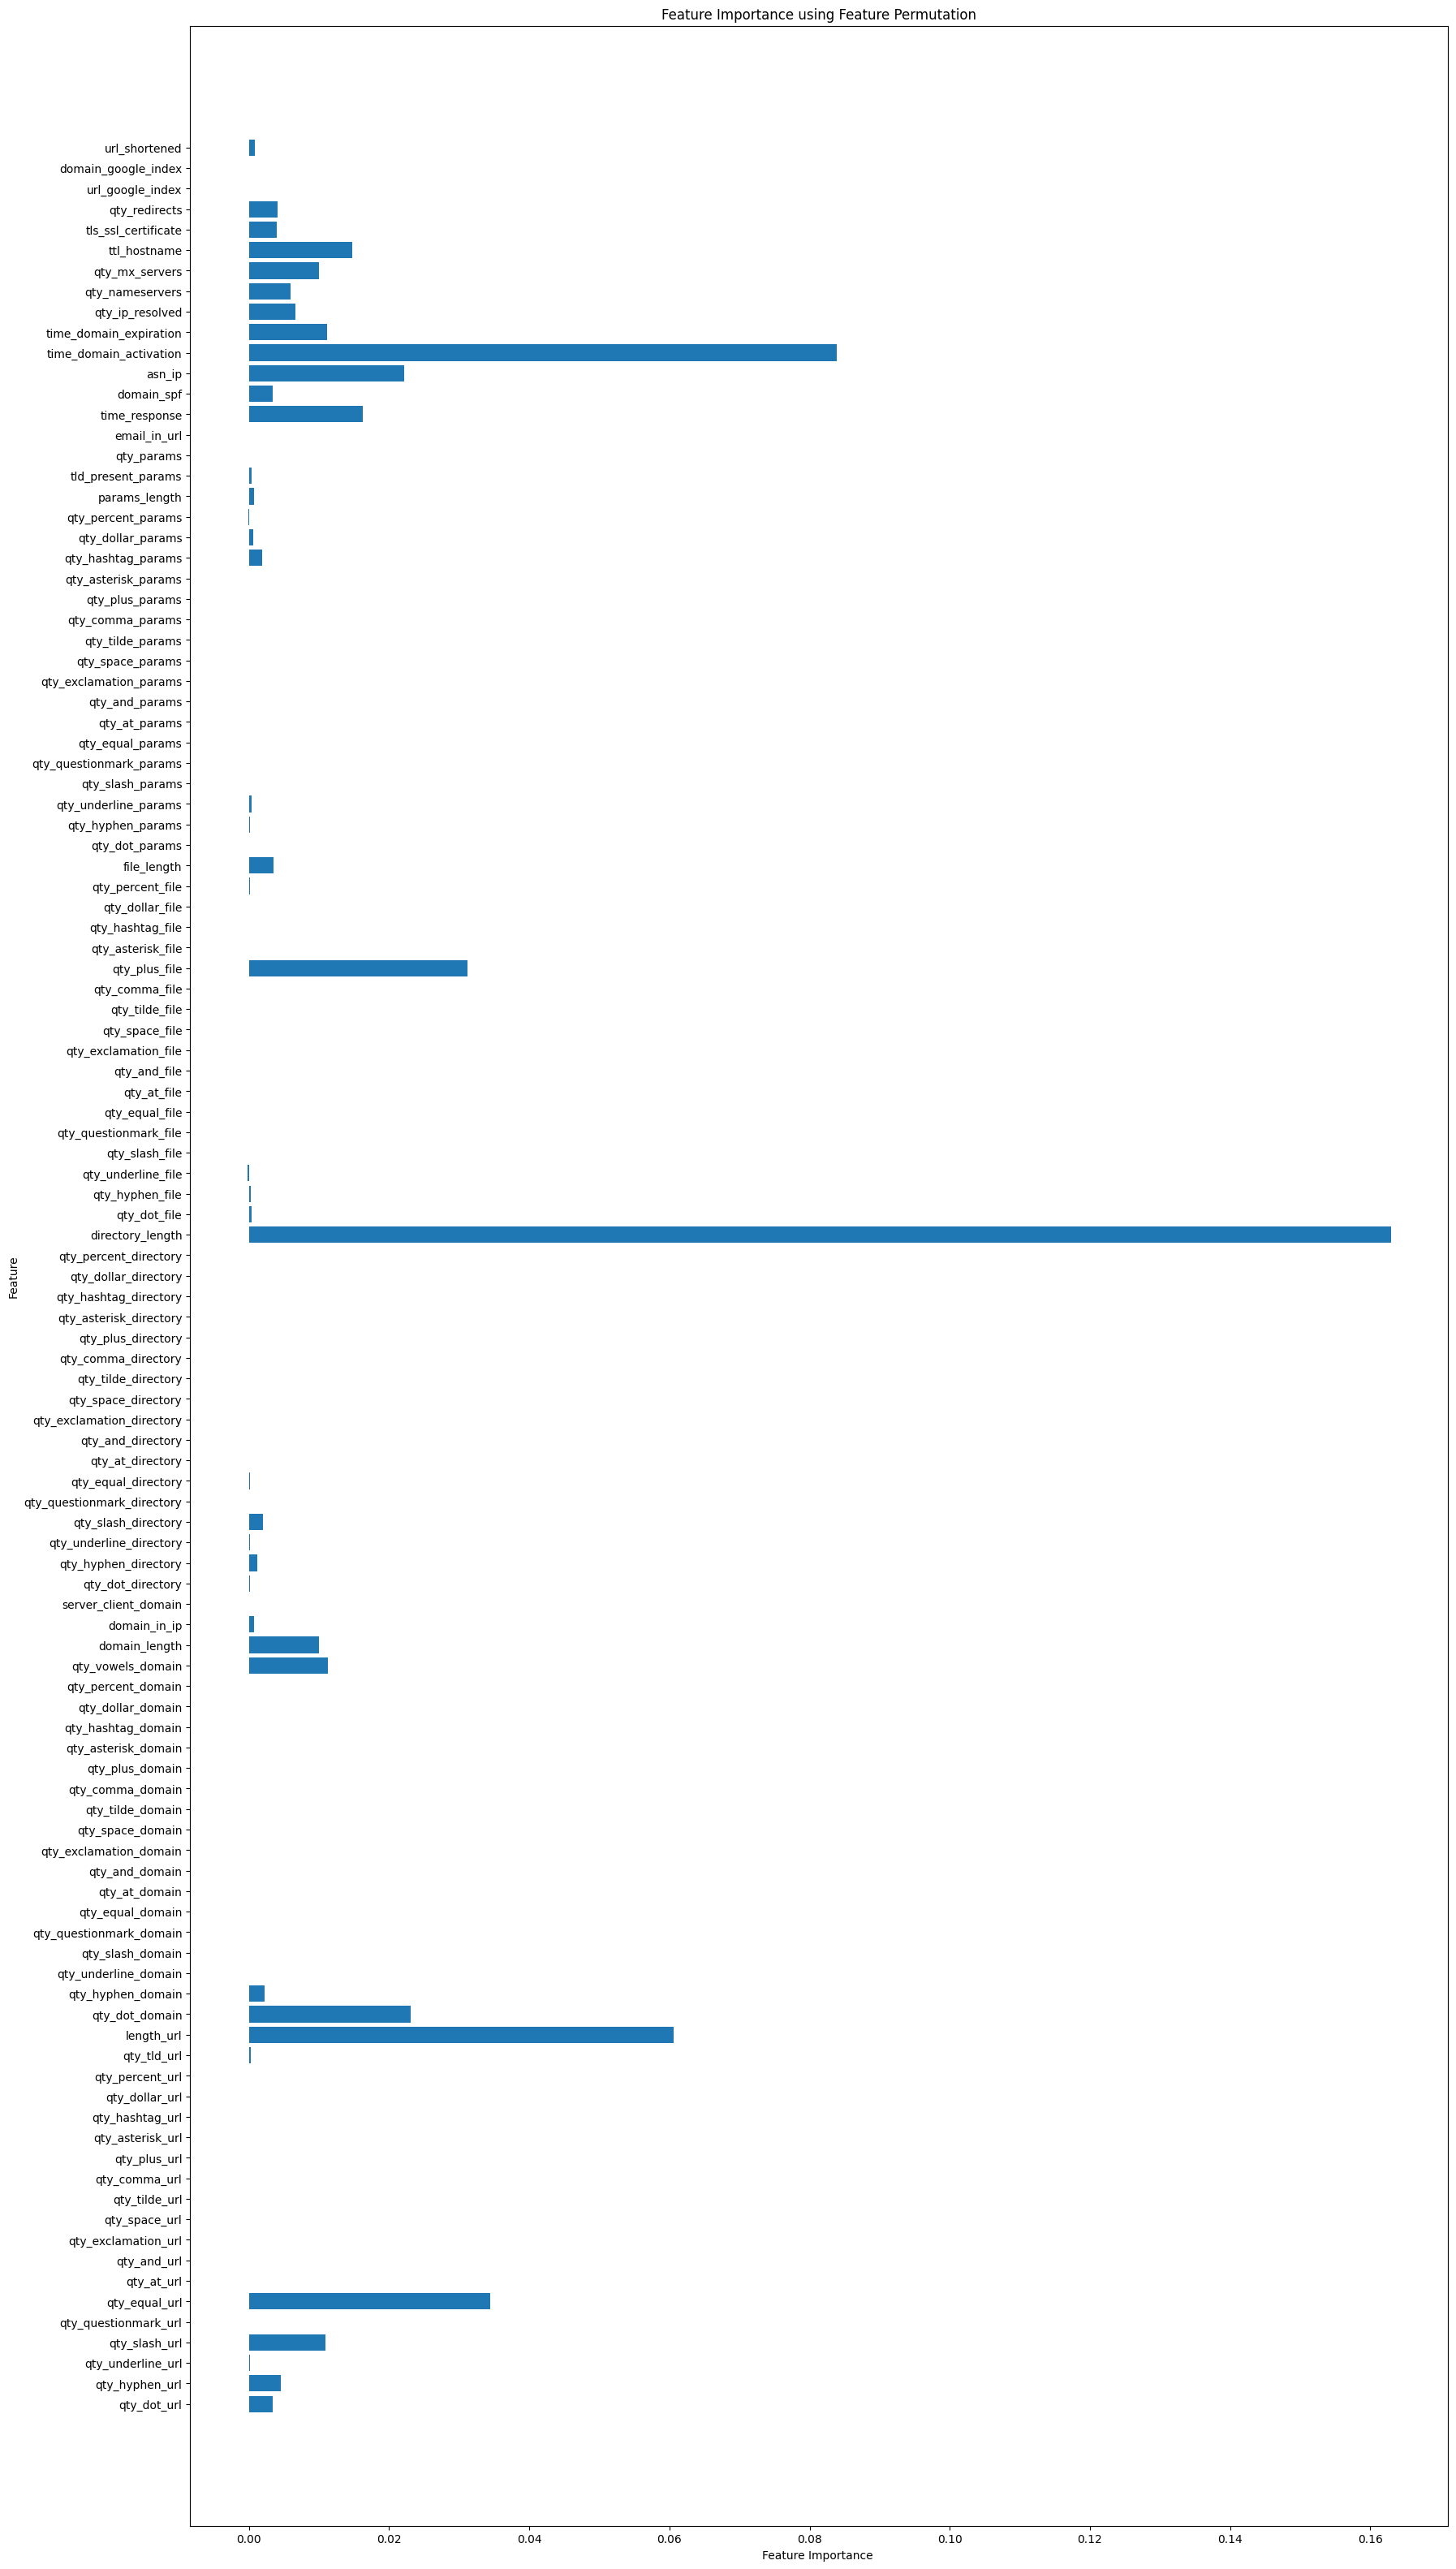

In [ ]:
plt.figure(figsize=(20,40))
plt.barh(range(X.shape[1]), importances, align='center')
plt.yticks(range(X.shape[1]), feature_names)
plt.title('Feature Importance using Feature Permutation')
plt.xlabel('Feature Importance ')
plt.ylabel('Feature')
plt.show()

In [ ]:
explainer = shap.TreeExplainer(tree)
shap_values = explainer(X)

# shap.initjs()?shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)
# shap.summary_plot(shap_values, X_test, class_names=["legitimate", "phishing"])
shap.plots.beeswarm(shap_values[0], max_display=10, show=False)
plt.title("SHAP values for diabetes dataset")
plt.xlabel("SHAP value")
plt.show()

#**Random Forest Implementation**


In [ ]:
forest = sklearn.ensemble.RandomForestClassifier(random_state=0).fit(X_train, y_train);

y_pred = forest.predict(X_train)

training_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

y_pred = forest.predict(X_test)

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('{:.2%} training accuracy'.format(training_accuracy))
print('{:.2%} training error'.format(1-training_accuracy))
print('{:.2%} test accuracy'.format(test_accuracy))
print('{:.2%} test error'.format(1-test_accuracy))

100.00% training accuracy
0.00% training error
96.98% test accuracy
3.02% test error


##Feature Importances

###Mean Decrease in Impurity (MDI)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

Text(0, 0.5, 'Mean decrease in impurity')

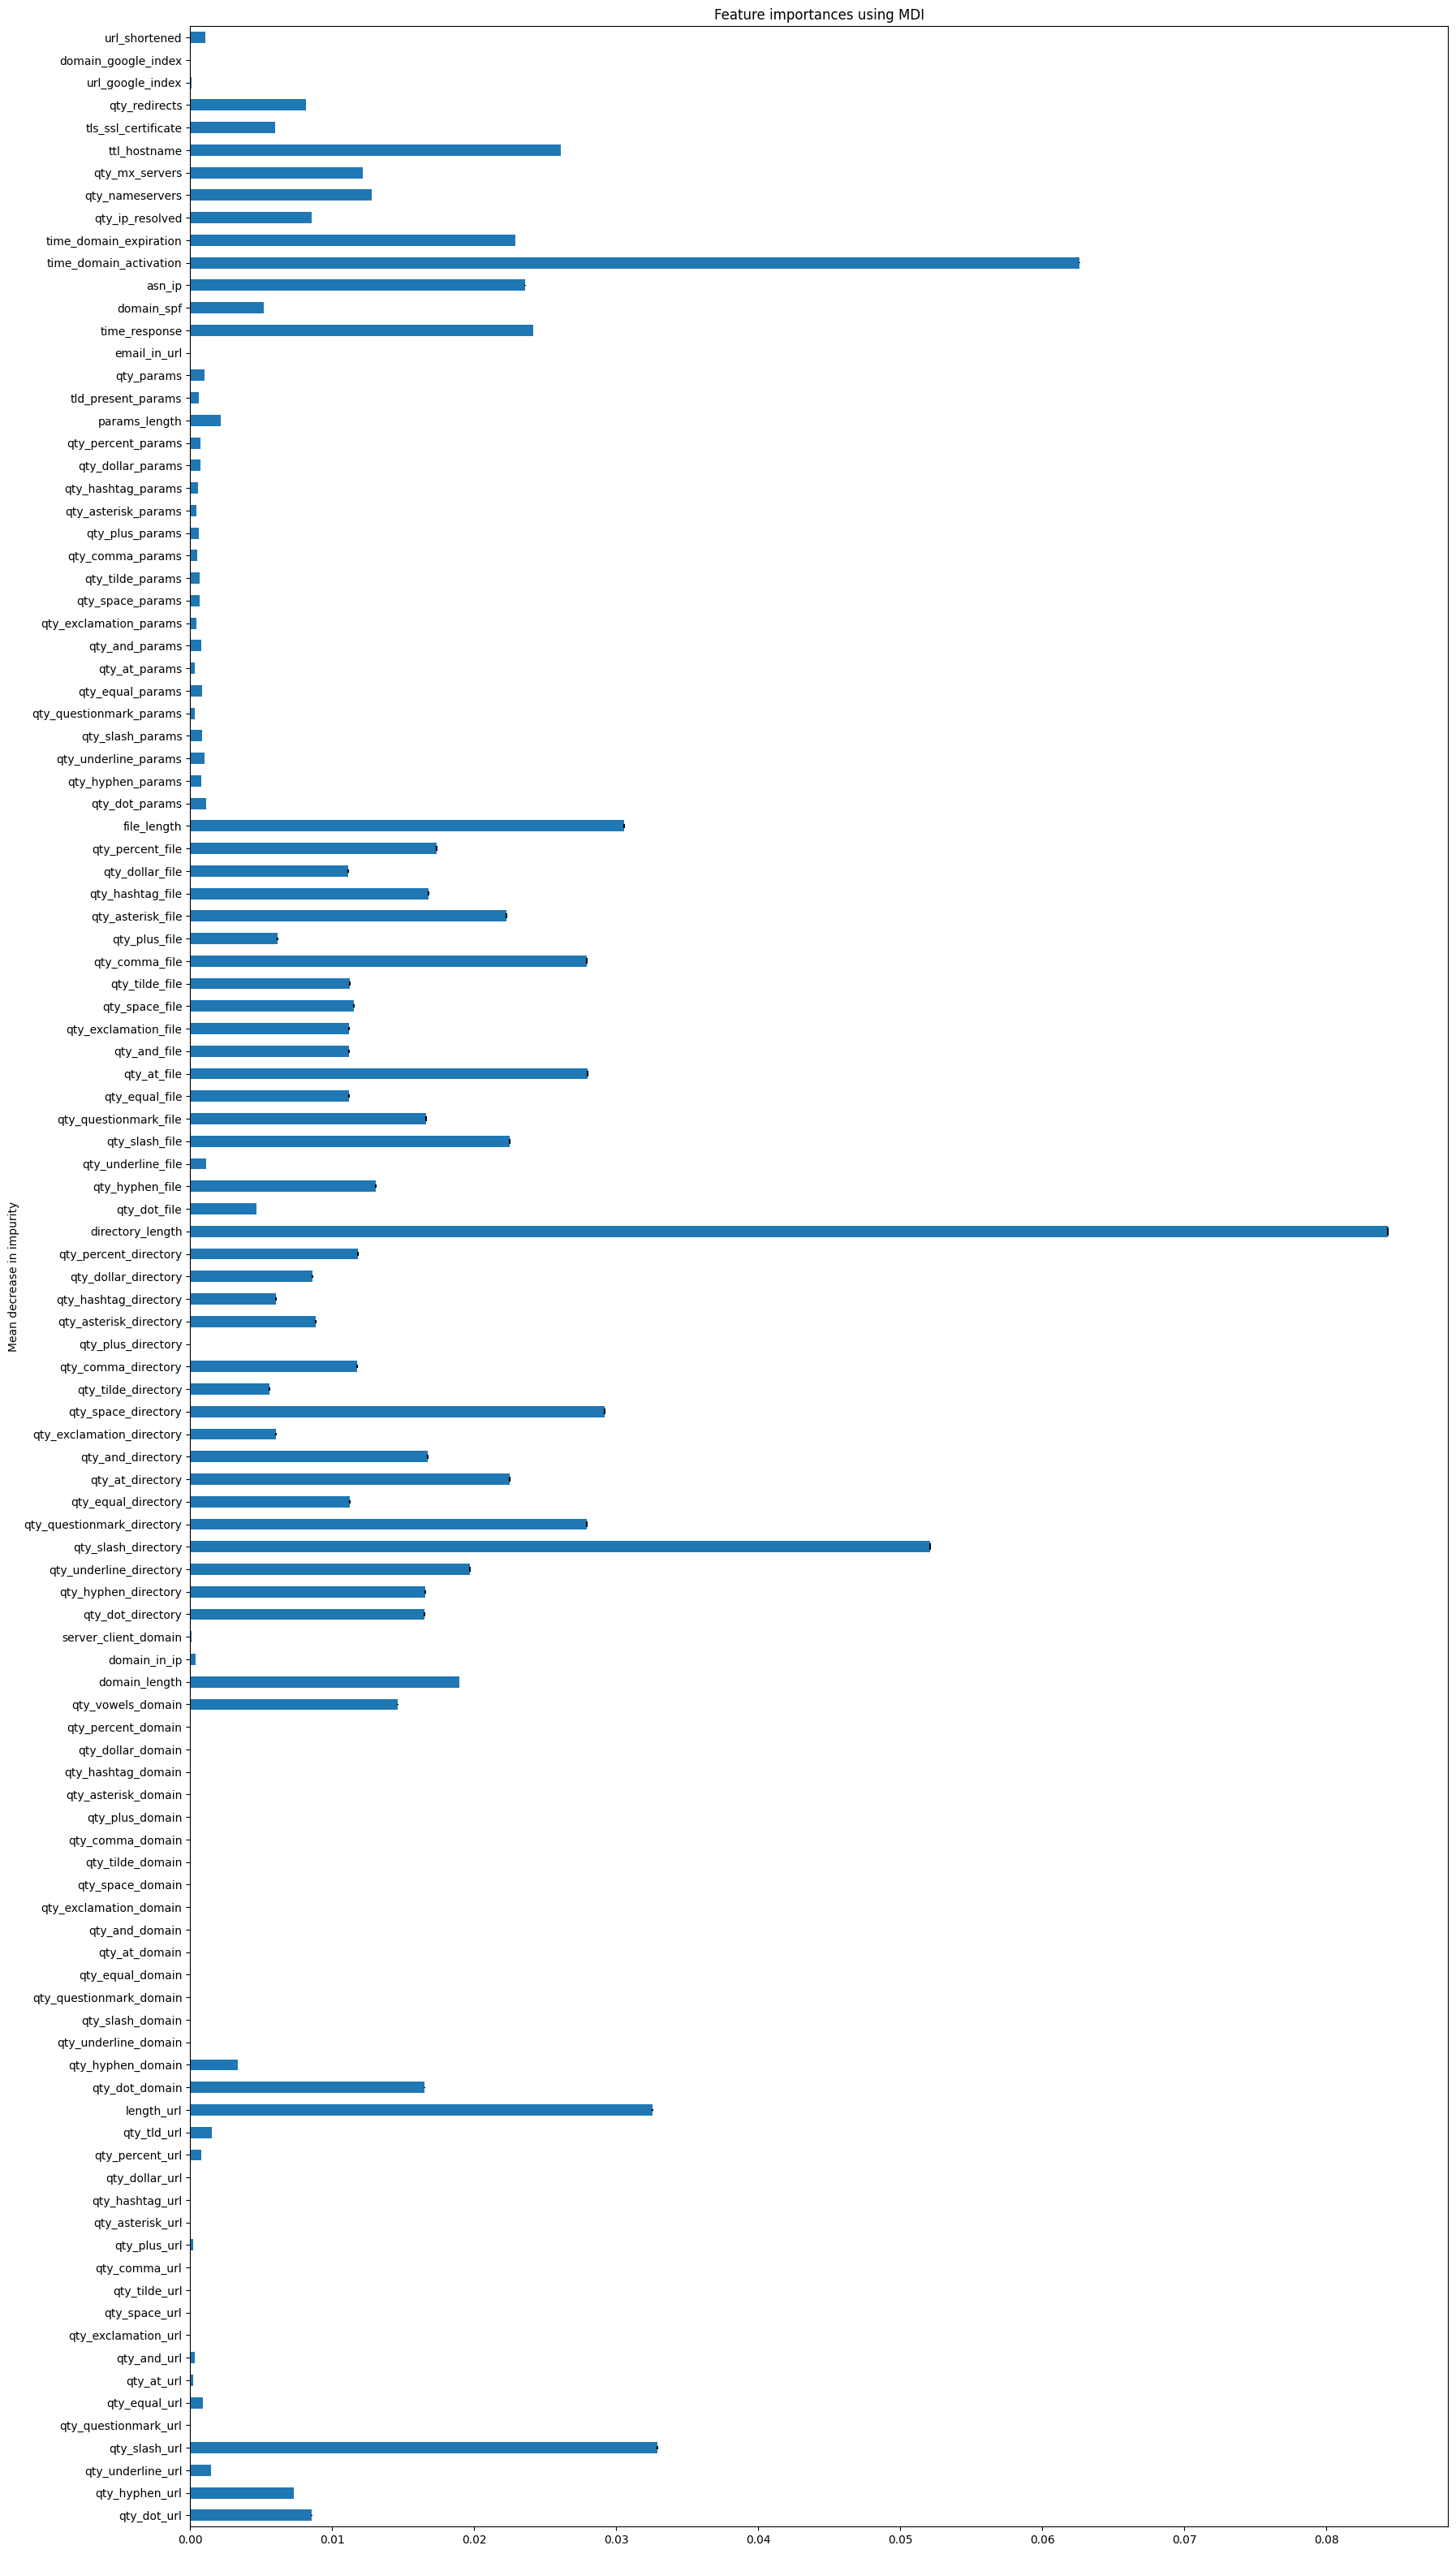

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20,40)
forest_importances.plot.barh(yerr=std, ax=ax, align='center')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

###Feature Permutation

In [ ]:
result = permutation_importance(forest, X_vali, y_vali, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean

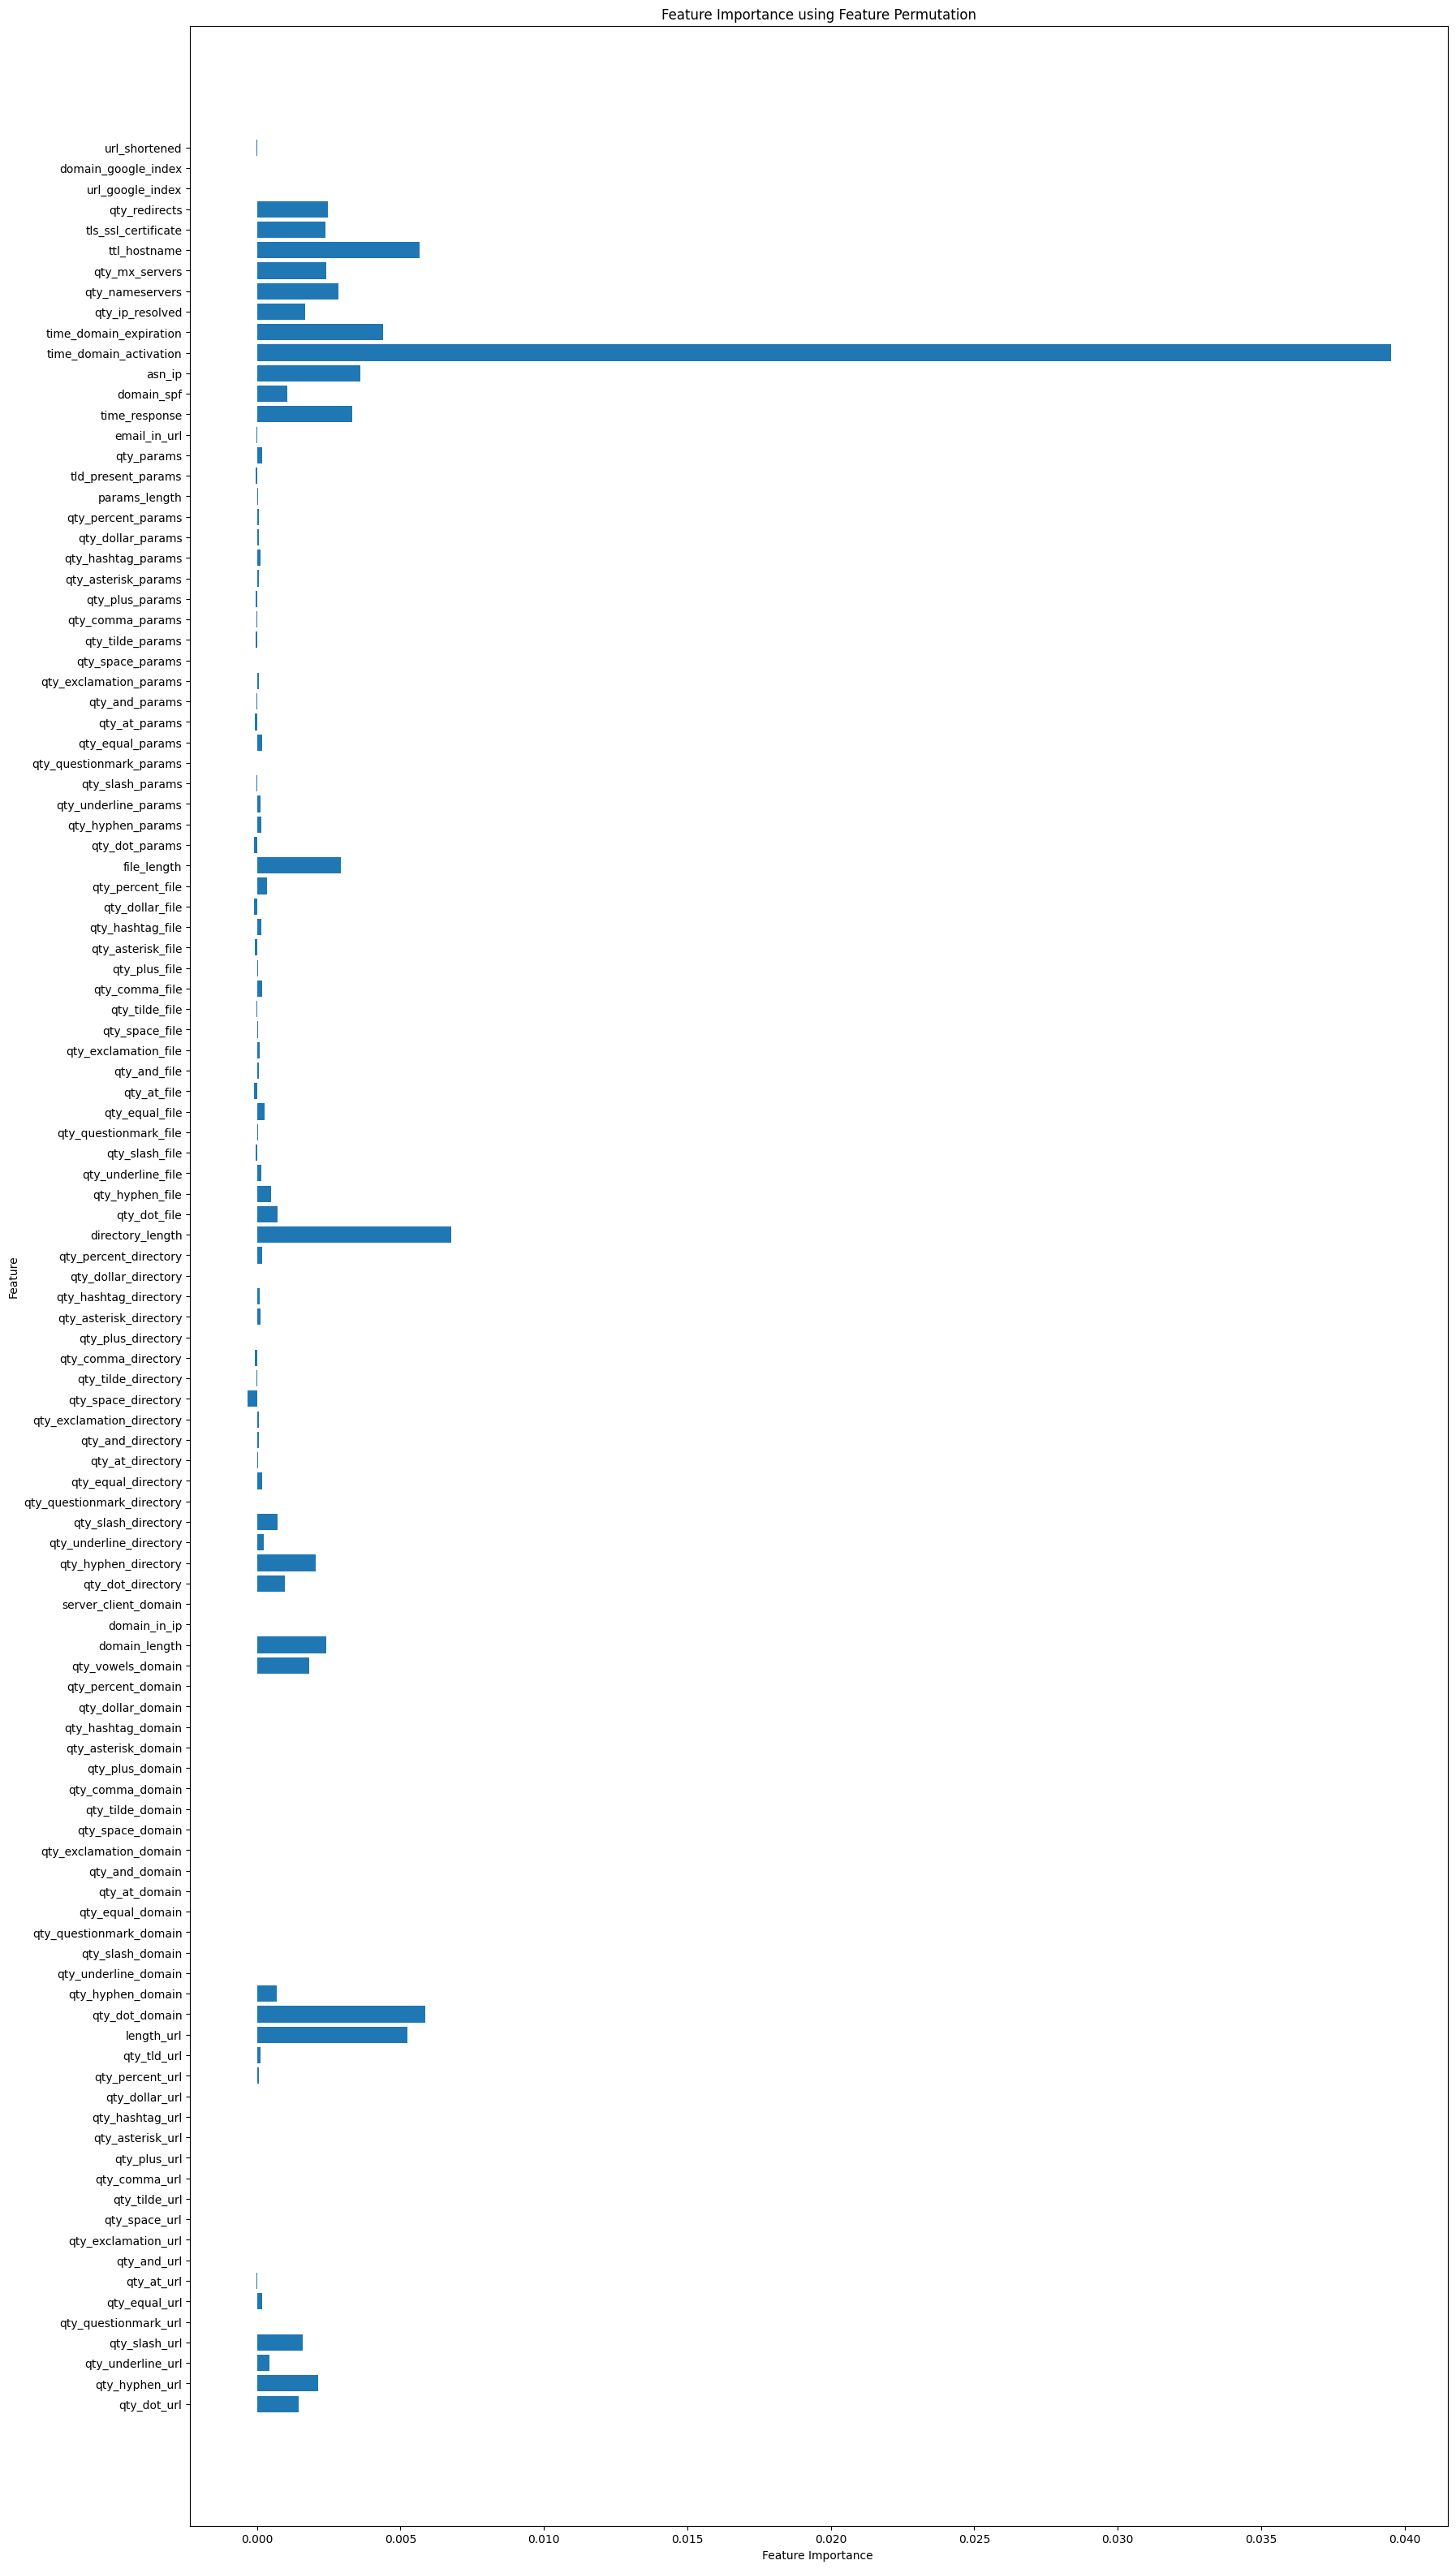

In [ ]:
plt.figure(figsize=(20,40))
plt.barh(range(X.shape[1]), importances, align='center')
plt.yticks(range(X.shape[1]), feature_names)
plt.title('Feature Importance using Feature Permutation')
plt.xlabel('Feature Importance ')
plt.ylabel('Feature')
plt.show()

##**Neural Network Implementation**


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert training data and labels to PyTorch tensors
X_train_torch = torch.Tensor(X_train_torch)
y_train_torch = torch.Tensor(y_train_torch).long()

# Create a dataset and data loader for the training set
train_dataset = TensorDataset(X_train_torch, y_train_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = nn.Sequential(
    nn.Linear(111, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
    nn.Softmax(dim=1)
)
# model = nn.Sequential(
#     nn.Linear(111, 55),
#     nn.ReLU(),
#     nn.Linear(55, 27),
#     nn.ReLU(),
#     nn.Linear(27, 2),
#     nn.Softmax(dim=1)
# )
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Train the model
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1)  # Reshape labels tensor to [batch_size]
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' %
                  (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, running_loss/(batch_size*i),))
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, epoch_loss, epoch_acc*100))




Epoch [1/20], Iter [10/1551] Loss: 0.7592
Epoch [1/20], Iter [20/1551] Loss: 0.7177
Epoch [1/20], Iter [30/1551] Loss: 0.6959
Epoch [1/20], Iter [40/1551] Loss: 0.6810
Epoch [1/20], Iter [50/1551] Loss: 0.6693
Epoch [1/20], Iter [60/1551] Loss: 0.6702
Epoch [1/20], Iter [70/1551] Loss: 0.6682
Epoch [1/20], Iter [80/1551] Loss: 0.6700
Epoch [1/20], Iter [90/1551] Loss: 0.6717
Epoch [1/20], Iter [100/1551] Loss: 0.6708
Epoch [1/20], Iter [110/1551] Loss: 0.6677
Epoch [1/20], Iter [120/1551] Loss: 0.6669
Epoch [1/20], Iter [130/1551] Loss: 0.6700
Epoch [1/20], Iter [140/1551] Loss: 0.6683
Epoch [1/20], Iter [150/1551] Loss: 0.6692
Epoch [1/20], Iter [160/1551] Loss: 0.6703
Epoch [1/20], Iter [170/1551] Loss: 0.6713
Epoch [1/20], Iter [180/1551] Loss: 0.6715
Epoch [1/20], Iter [190/1551] Loss: 0.6684
Epoch [1/20], Iter [200/1551] Loss: 0.6671
Epoch [1/20], Iter [210/1551] Loss: 0.6664
Epoch [1/20], Iter [220/1551] Loss: 0.6660
Epoch [1/20], Iter [230/1551] Loss: 0.6658
Epoch [1/20], Iter [

In [ ]:
import IPython
from markdown import markdown
Markdown = lambda string: IPython.display.HTML(markdown(string))

Markdown("<b style='color: blue'>dfsfd</b>")

# url

#for l in "https://colab.research.google.com/drive/1zrNmACKzueerBEqoCXnrYLjKSrPyzwvt#scrollTo=-V0xg319UUOh":

#**References**

Vrbančič, Grega (2020), “Phishing Websites Dataset”, Mendeley Data, V1, doi: 10.17632/72ptz43s9v.1